In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import numpy as np
import anndata
import scanpy as sc
from scipy import sparse
from kladi.matrix_models.accessibility_model import AccessibilityModel
from kladi.matrix_models.expression_model import ExpressionModel
from kladi.motif_scanning import moods_scan

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import seaborn as sns
sns.set(style = 'ticks')

### Read expression data

In [141]:
gex_data = anndata.read_h5ad('./data/shareseq/2021-05-05_just_raw_counts.h5ad')
gex_data.var.index = gex_data.var.index.str.upper()
gex_data=gex_data[:,~gex_data.var.index.duplicated()]

with open('data/shareseq/model_genes.txt', 'r') as f:
    gois = [x.strip() for x  in f]

sc.pp.filter_genes(gex_data, min_counts=5)

gex_data.layers["counts"] = gex_data.X.copy() # preserve counts
sc.pp.normalize_total(gex_data, target_sum=1e4)
sc.pp.log1p(gex_data)
gex_data.raw = gex_data # freeze the state in `.raw`

Trying to set attribute `.var` of view, copying.


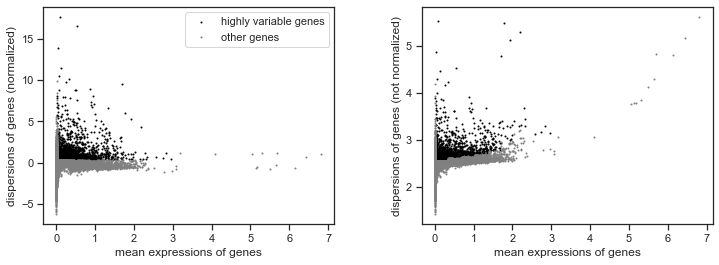

3894

In [145]:
sc.pp.highly_variable_genes(gex_data, min_mean=0.015, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(gex_data)
gex_data.var.highly_variable.sum()

In [5]:
variable_genes = gex_data[:, gex_data.var.highly_variable].var.index.values
gois = np.union1d(gois, variable_genes)

In [6]:
len(gois)

6646

In [7]:
with open('/Users/alynch/Dropbox (Partners HealthCare)/Data/shareseq/all_variable_genes.txt', 'w') as f:
    print(*gois, sep = '\n', file = f)
with open('/Users/alynch/Dropbox (Partners HealthCare)/Data/shareseq/most_variable.txt', 'w') as f:
    print(*variable_genes, sep = '\n', file = f)

In [8]:
gex_data=gex_data[:, gois]

In [9]:
expr_model = ExpressionModel(gois, highly_variable=np.isin(gois, variable_genes), num_modules=32)

INFO:root:Using CUDA: False


# Training GEX model

In [10]:
expr_model.load('/Users/alynch/Dropbox (Partners HealthCare)/Data/shareseq/2021-04-28-test2.pth')

gex_data.obsm['rna_topics'] = expr_model.predict(gex_data.layers['counts'])

INFO:root:Moving model to device: cpu
INFO:root:Predicting latent variables ...


In [11]:
gex_data.layers['imputed'] = expr_model.impute(gex_data.obsm['rna_topics'])

# Reading ATAC data

In [12]:
atac_data = anndata.read_h5ad('data/shareseq/2021-02-01_atac_data.h5ad')
peaks = np.array(atac_data.var[['chr','start','end']].values.tolist())

atac_model = AccessibilityModel(peaks, num_modules = 24)
atac_model.load('data/shareseq/test_save.pth')

INFO:root:Using CUDA: False
INFO:root:Moving model to device: cpu


In [13]:
gex_data.obsm['atac_topics'] = atac_model.predict(atac_data.X)

INFO:root:Binarizing accessibility matrix ...
INFO:root:Predicting latent variables ...
100%|██████████| 1087/1087 [01:35<00:00, 11.43it/s]


# Joint representation

In [14]:
from kladi.matrix_models.ilr import ilr,clr

In [103]:
gex_data.obsm['joint'] = np.hstack([2*clr(gex_data.obsm['rna_topics']), clr(gex_data.obsm['atac_topics'])])
gex_data.obsm['joint_topics'] = np.hstack([1.5*gex_data.obsm['rna_topics'], gex_data.obsm['atac_topics']])
sc.pp.neighbors(gex_data, use_rep='joint', metric='manhattan')
sc.tl.umap(gex_data, negative_sample_rate=1, min_dist = 0.1)

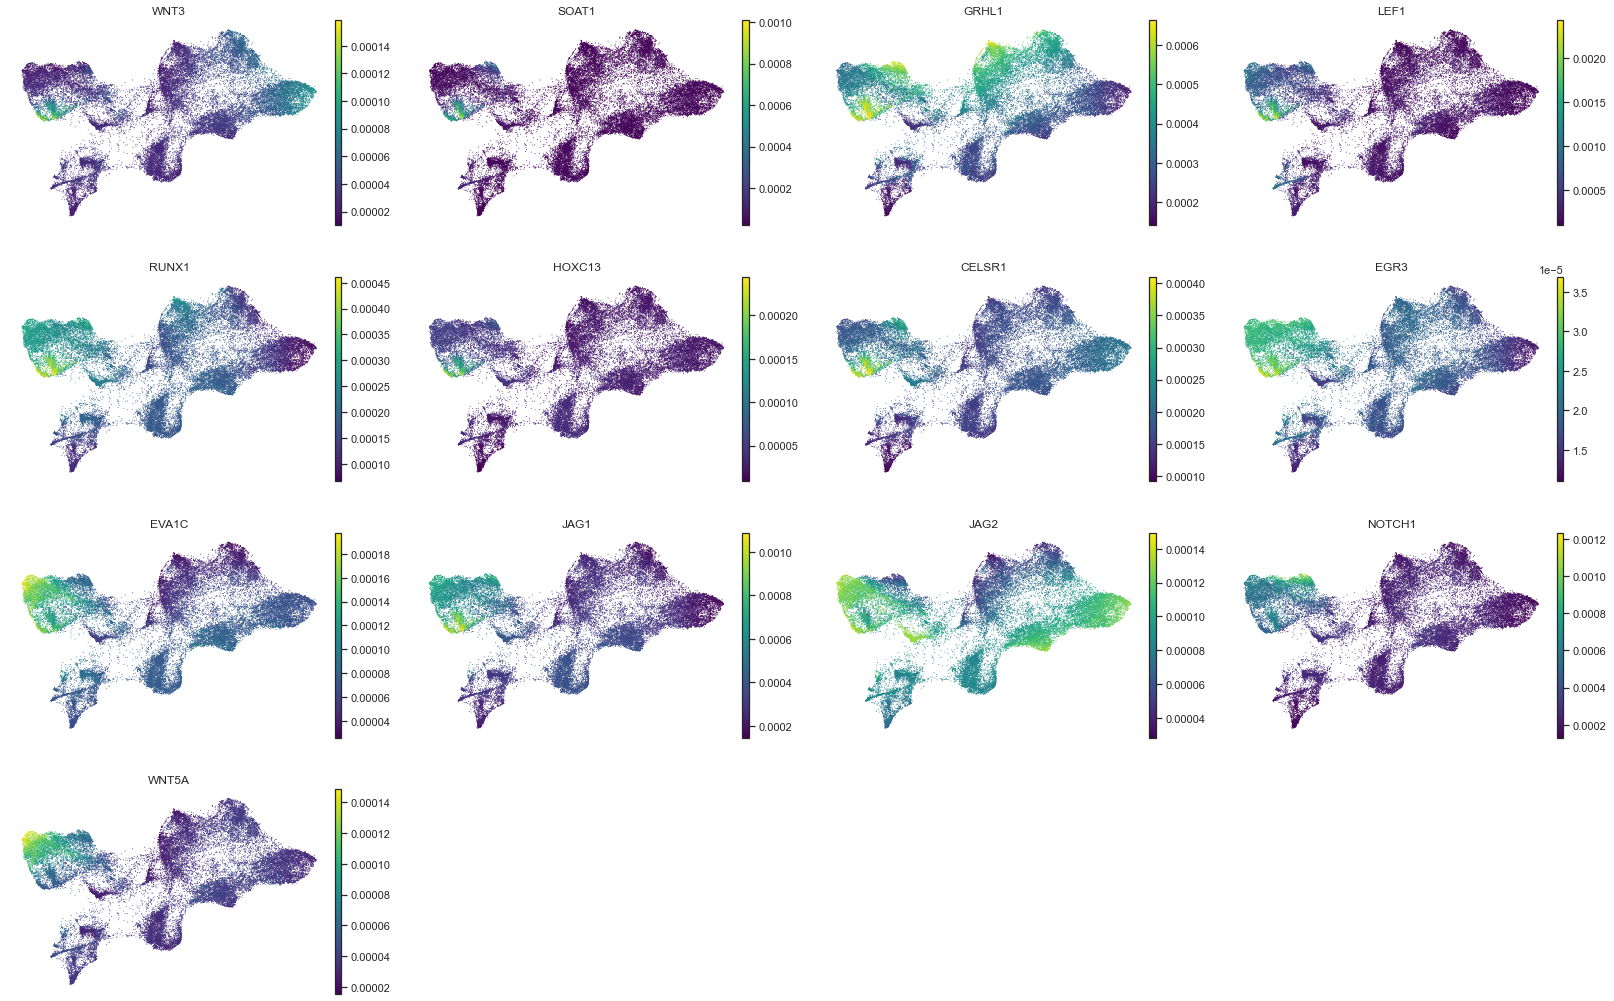

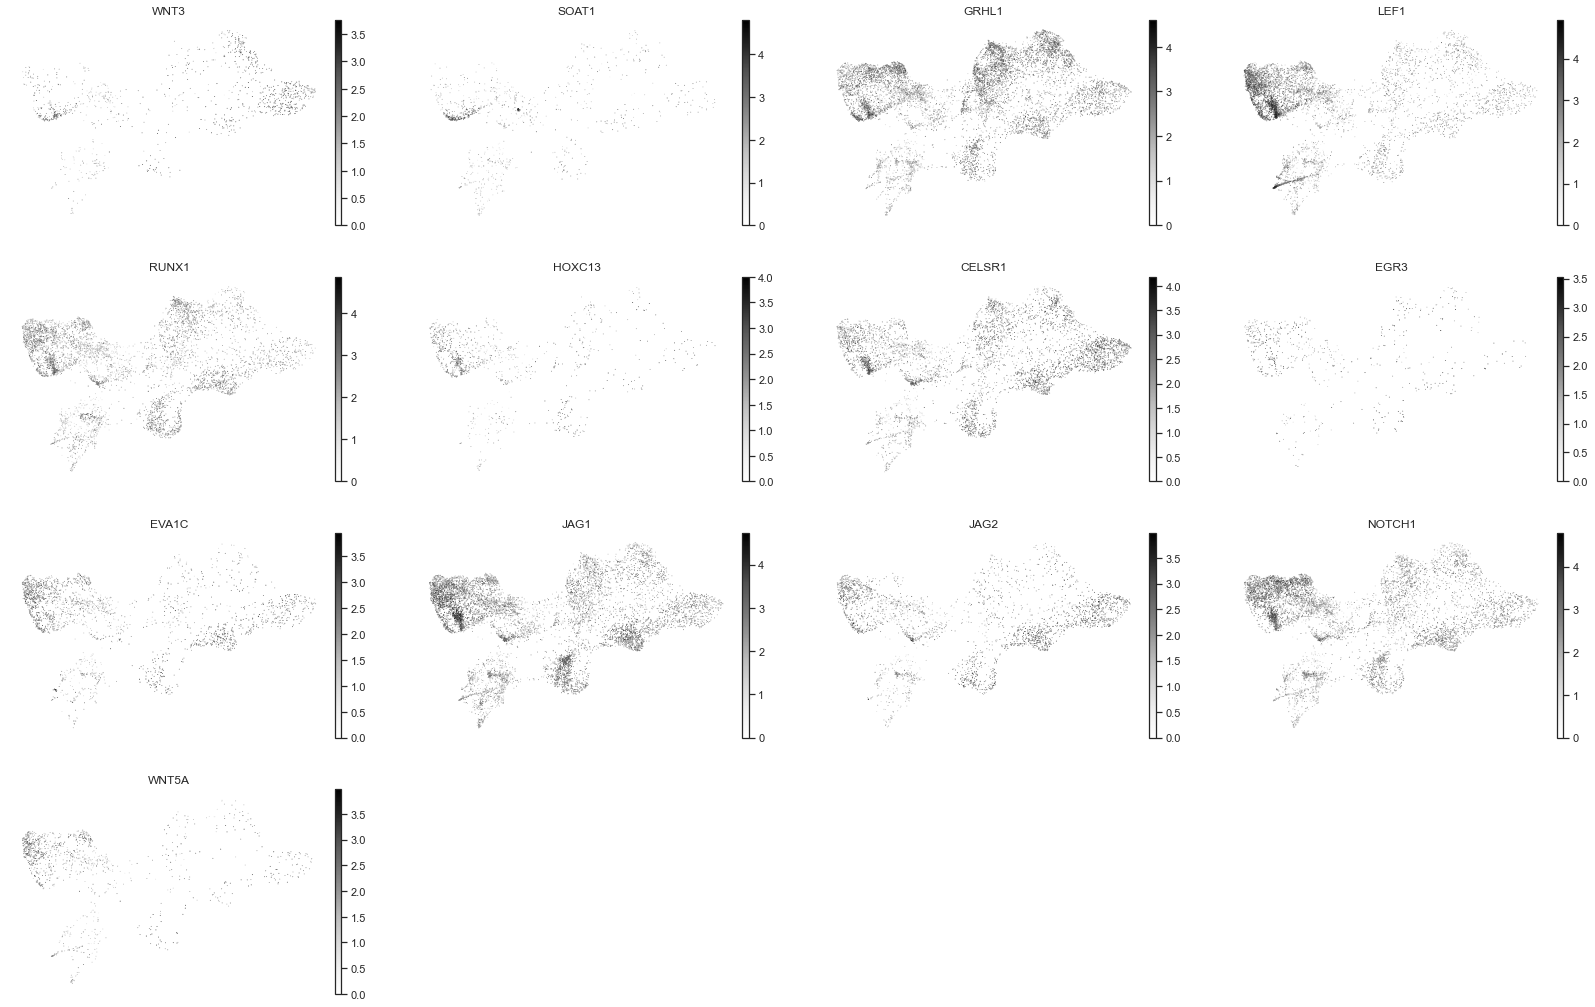

In [104]:
interesting_genes = ['WNT3','SOAT1','GRHL1','LEF1','RUNX1','HOXC13', 'CELSR1', 'EGR3','EVA1C','JAG1','JAG2','NOTCH1', 'WNT5A']
sc.pl.umap(gex_data, color=interesting_genes, color_map='viridis', layer='imputed', frameon=False)
sc.pl.umap(gex_data, color=interesting_genes, color_map='Greys', frameon=False)

In [18]:
gex_data.obs[['rna_{}'.format(str(i)) for i in range(32)]] = gex_data.obsm['rna_topics']

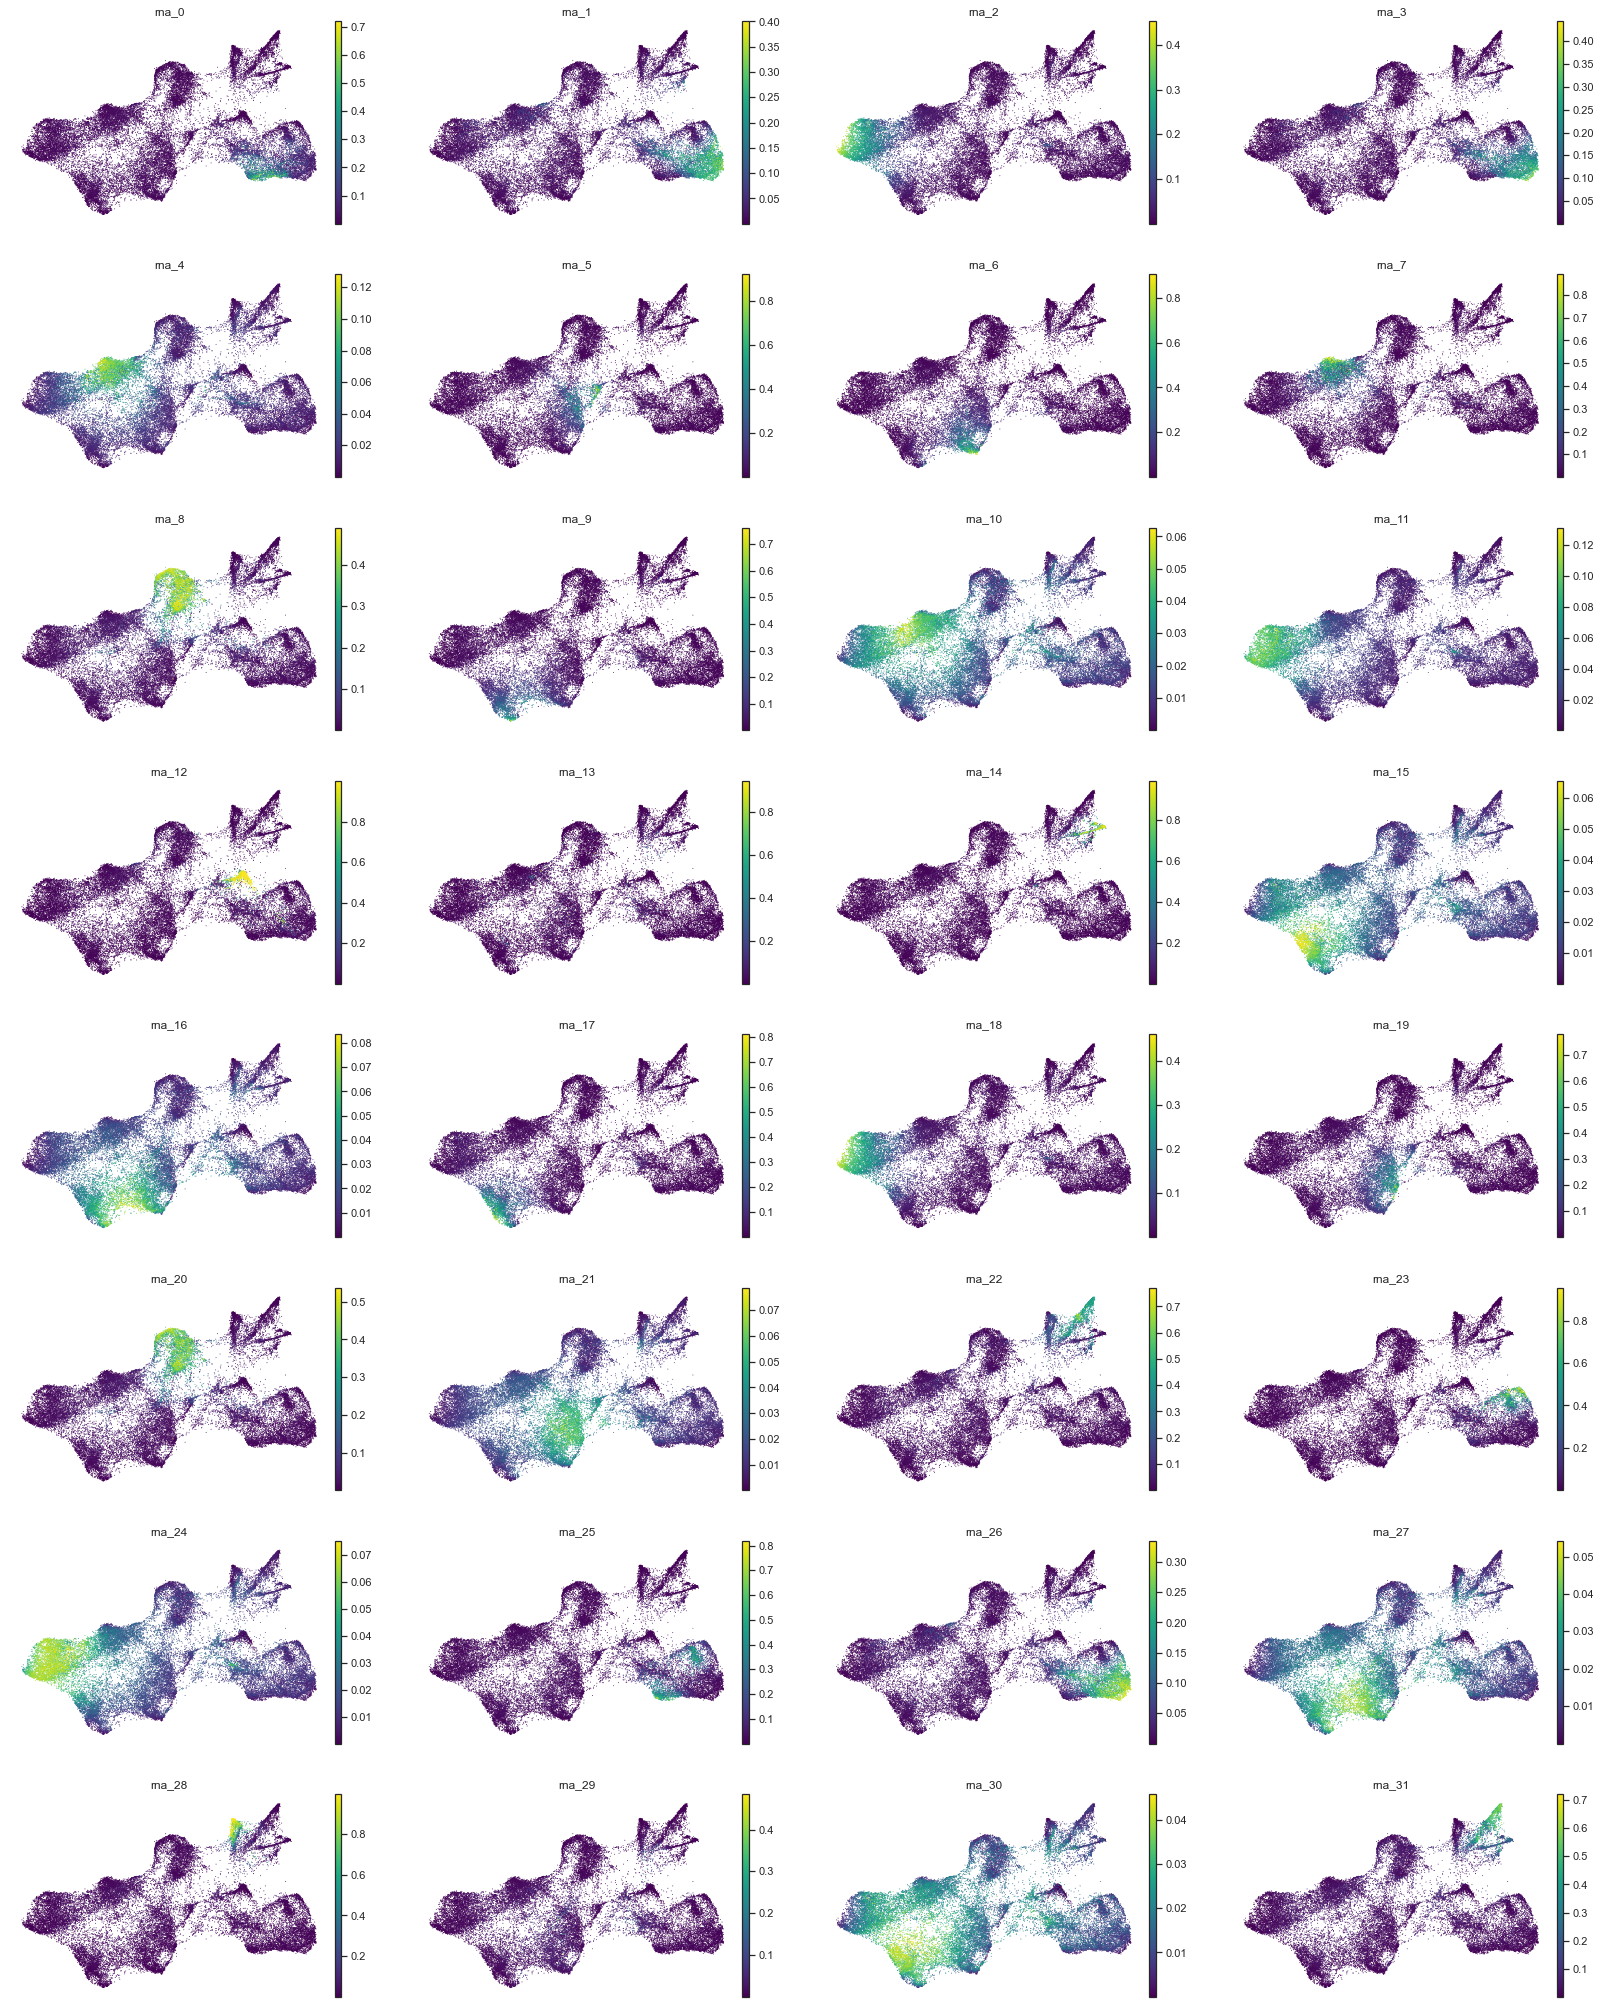

In [19]:
sc.pl.umap(gex_data, color=['rna_{}'.format(str(i)) for i in range(32)], color_map='viridis', frameon=False)

In [73]:
enrichments = expr_model.get_enrichments(expr_model.post_genelist(25, top_n_genes=250))

INFO:root:Querying Enrichr with module 25 genes.
INFO:root:Downloading results ...


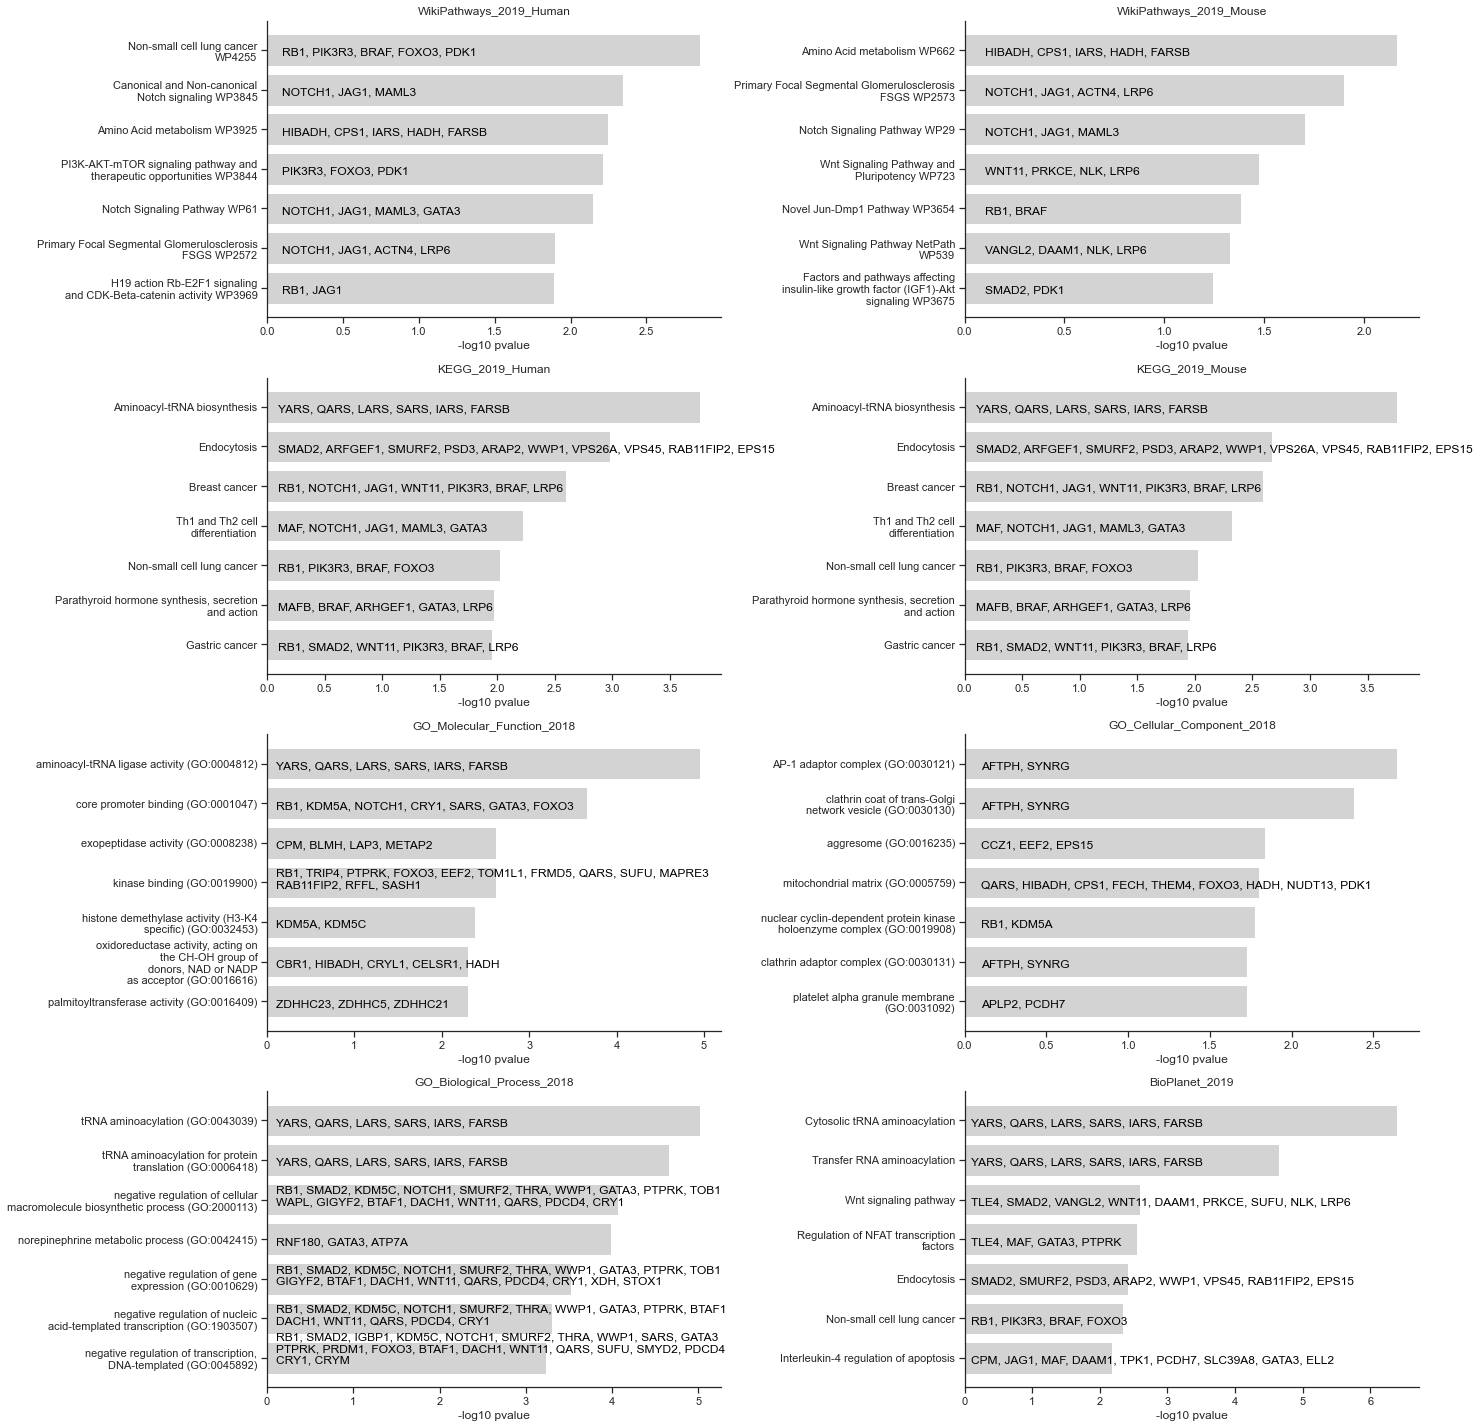

In [74]:
expr_model.plot_enrichments(enrichments, show_top=7, show_genes = True)

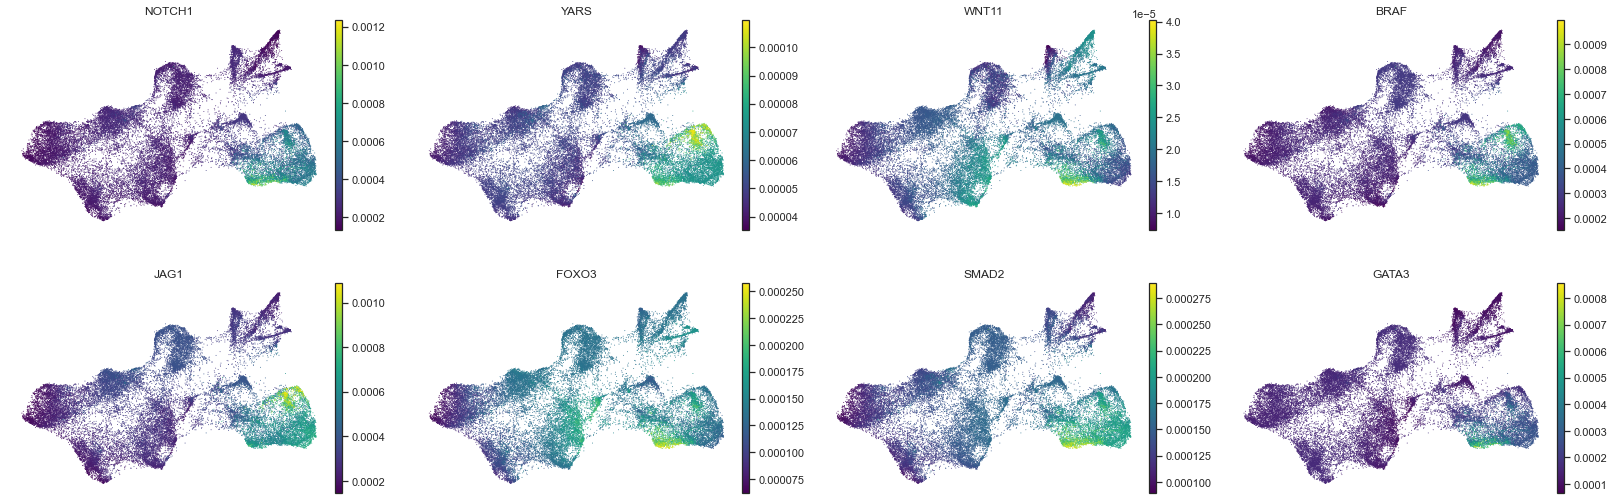

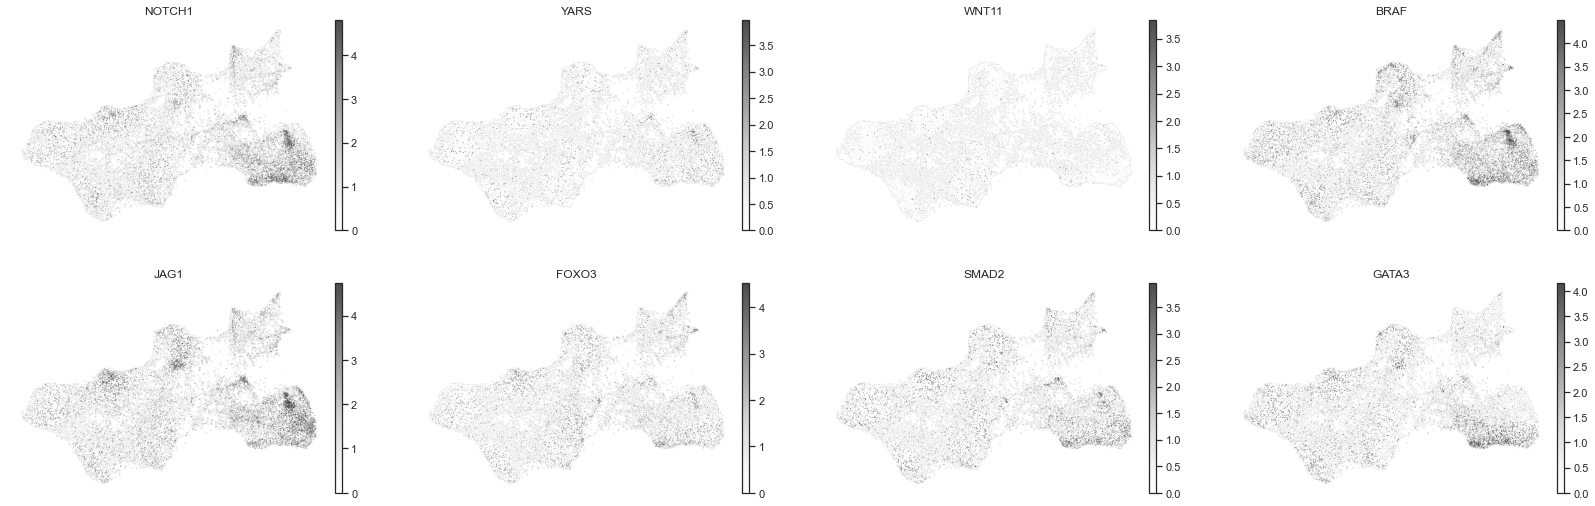

In [81]:
interesting_genes = ['NOTCH1','YARS','WNT11','BRAF','JAG1','FOXO3','SMAD2', 'GATA3']
sc.pl.umap(gex_data, color=interesting_genes, color_map='viridis', layer='imputed', frameon=False)
sc.pl.umap(gex_data, color=interesting_genes, color_map='Greys', frameon=False, outline_color=('lightgrey', 'white'), add_outline=True)

In [105]:
sc.tl.leiden(gex_data, resolution=0.8)

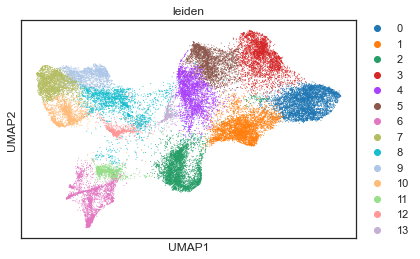

In [106]:
sc.pl.umap(gex_data, color = 'leiden')

In [135]:
hair_follicle = gex_data[np.isin(gex_data.obs.leiden.values, ['10','7','9'])]

In [120]:
#sc.pp.neighbors(hair_follicle, use_rep='joint', metric='manhattan')

In [121]:
#sc.tl.umap(hair_follicle, min_dist = 0.1, negative_sample_rate=1, n_components=3)

In [122]:
from kladi.core.plot_utils import plot_umap

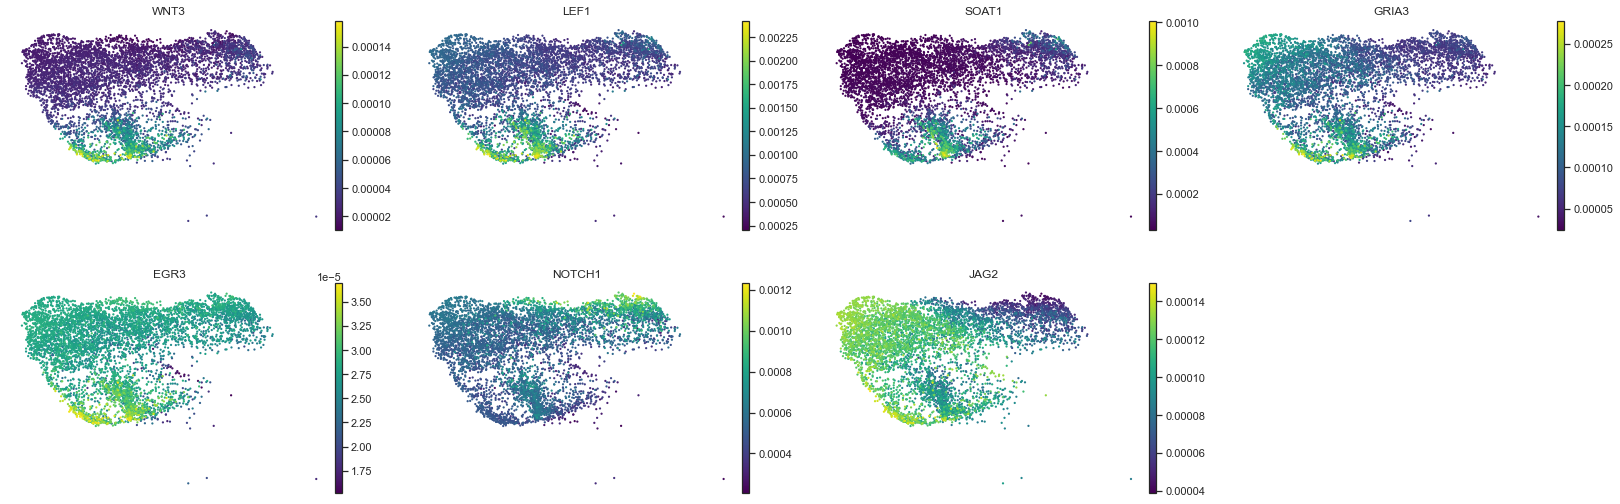

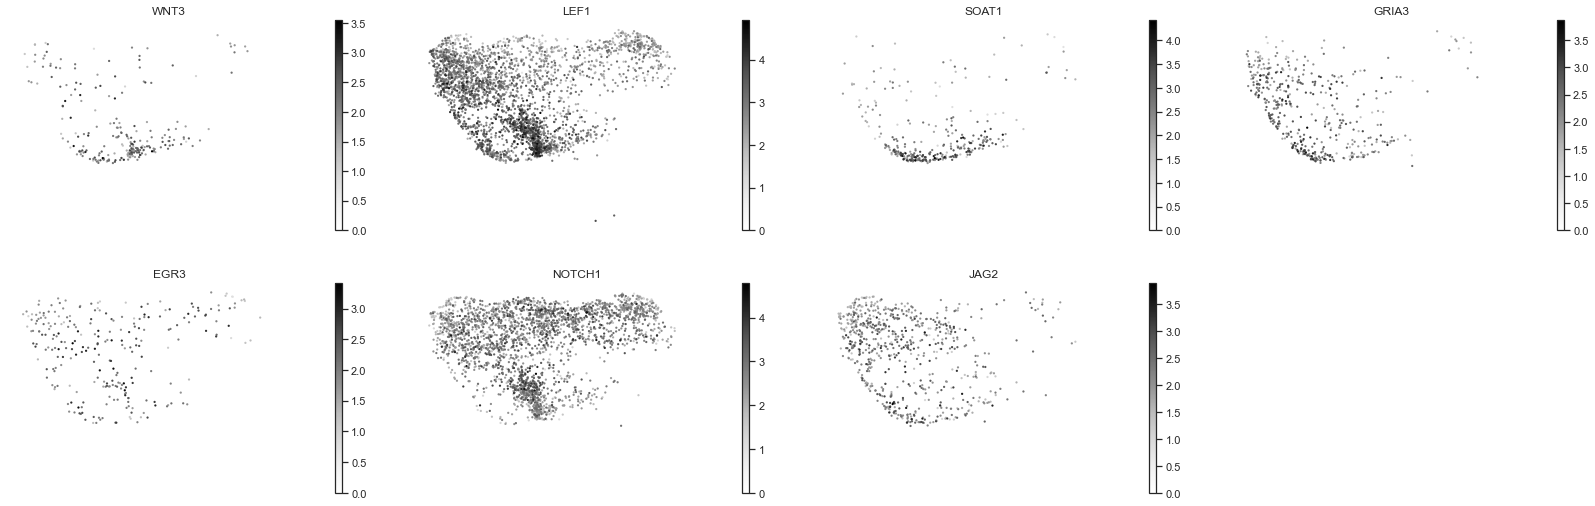

In [136]:
sc.pl.umap(hair_follicle, color = ['WNT3','LEF1','SOAT1','GRIA3', 'EGR3','NOTCH1', 'JAG2'], frameon=False, layer='imputed', color_map='viridis')
sc.pl.umap(hair_follicle, color = ['WNT3','LEF1','SOAT1','GRIA3', 'EGR3','NOTCH1', 'JAG2'], frameon=False, color_map='Greys')

In [150]:
hair_follicle.write_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/Data/shareseq/follicle_data.h5ad')